In [6]:
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np

#import torch
#import torch.nn as nn
#import torch.optim as optim
#import linalg
#import sklearn
#from sklearn import preprocessing
#import scipy 

#from mpl_toolkits.mplot3d import Axes3D

In [7]:
uAmax1=12.0                 # Maximalspannung Pumpe 1
uAmax2=12.0                 # Maximalspannung Pumpe 2

#from settingsV2V3

# -*- coding: utf-8 -*-
# ----------------------------------------------------------------------------------------------------------
# Globale Einstellungen für die physikalische Simulation für 4-Tanksystem bestehend aus Versuchsstand 2 u. 3
# ----------------------------------------------------------------------------------------------------------
# Dabei ist der obere Versuchsstand V3 und der untere V2
# Bei den Ventilabflüssen wird folgende Nomenklatur verwendet: 
# Prefix immer AS dann zwei Zahlen: erste Zahl = welcher Tank, zweite Zahl = welches Ventil

# Pumpe
Ku1 = 2.47005e-05            # m**3 / (s V) - Verstärkung der Pumpe (V3)
Ku2 = 2.62564e-05            # m**3 / (s V) - Verstärkung der Pumpe (V2)
uA01 = 8.0                   # V - Spannung ab welcher die Pumpe Wasser fördert über pywisp bestimmt (V3)
uA02 = 6.6                   # V - Spannung ab welcher die Pumpe Wasser fördert über pywisp bestimmt (V2)

# Tank 1 (Tank 1 V3)
rT1 = 0.060195545420039      # m - effektiver Radius des Tank 1 V2
AT1 = np.pi * rT1 ** 2       # m**2 - Tankquerschnitt 1
AS13 = 2.410284e-05          # m**2 - Abflussquerschnitt von Tank 1 - Ventil11 zu Tank 3 mit 2.75 Umdrehung geschlossen
AS12 = 8.821075e-06          # m**2 - Abflussquerschnitt von Tank 1 - Ventil12 zu Tank 2 mit 2.75 Umdrehung geschlossen
hV1 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil
hT1 = 0.3                    # m - Höhe Tank 1

# Tank 2 (Tank 1 V2)
rT2 = 0.060195545420039      # m - effektiver Radius des Tank 1 V3
AT2 = np.pi * rT2 ** 2       # m**2 - Tankquerschnitt 2
hV2 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil
hT2 = 0.3                    # m - Höhe Tank 2
AS23 = 2.380935e-05          # m**2 - Abflussquerschnitt von Tank 2 - Ventil11 zu Tank 3 mit 2.00 Umdrehung geschlossen
AS24 = 3.106653e-05          # m**2 - Abflussquerschnitt von Tank 2 - Ventil12 zu Tank 4 mit 2.75 Umdrehung geschlossen

# Tank 3 (Tank 2 V3)
rT3 = 0.060195545420039      # m - effektiver Radius des Tank 2 V2
AT3 = np.pi * rT3 ** 2       # m**2 - Tankquerschnitt 3
hV3 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil
hT3 = 0.3                    # m - Höhe Tank 3
AS34 = 1.276023e-05          # m**2 - Abflussquerschnitt von Tank 3 - Ventil22 zu Tank 4 mit 2.00 Umdrehungen geschlossen
AS30 = 4.632738e-05          # m**2 - Abflussquerschnitt von Tank 3 - Ventil21 zu Reservoir mit 2.75 Umdrehungen geschlossen

# Tank 4 (Tank 2 V2)
rT4 = 0.060195545420039      # m - effektiver Radius des Tank 2 V3
AT4 = np.pi * rT4 ** 2       # m**2 - Tankquerschnitt 4
hV4 = 0.055                  # m - Höhe zwischen Nullniveau und Ventil zwischen Tank 4 und Reservoir
hT4 = 0.3                    # m - Höhe Tank 4
AS40 = 3.674956e-05          # m**2 - Abflussquerschnitt von Tank 4 - Ventil22 zu Reservoir mit 2.00 Umdrehungen geschlossen

g = 9.81                     # m / s**2 - Erdbeschleunigung

scale = 2                    # Skalierung für die Visualisierung


initial_state = [0, 0, 0, 0]



## 3.1 Ruhelagen

Die Ruhelagen werden mithilfe des sympy-Packages symbolisch berechnet.

In [8]:
# Steady state value symbolic calculation
# We assume that the heights x3 and x4 are static
# Since x3 and x4 are the flat variables of our three tank system we can 
# describe all other variables using these two variables

x3_bar, x4_bar = sp.symbols('x3_bar x4_bar')
Q_30 = AS30 * sp.sqrt(2 * g * (x3_bar + hV3))
Q_34 = AS34 * sp.sqrt(2 * g * (x3_bar + hV3))
Q_40 = AS40 * sp.sqrt(2 * g * (x4_bar + hV4))

x2_bar = (1 / AS24 * (Q_40 - Q_34)) ** 2 * 1 / (2 * g) - hV2
Q_24 = AS24 * sp.sqrt(2 * g * (x2_bar + hV2))
Q_23 = AS23 * sp.sqrt(2 * g * (x2_bar + hV2))

x1_bar = (1 / AS13 * (Q_30 + Q_34 - Q_23)) ** 2 * 1 / (2 * g) - hV1
Q_12 = AS12 * sp.sqrt(2 * g * (x1_bar + hV1))
Q_13 = AS13 * sp.sqrt(2 * g * (x1_bar + hV1))

Q_01 = Q_12 + Q_13
Q_02 = Q_23 + Q_24 - Q_12

U_A1 = Q_01 / Ku1 + uA01
U_A2 = Q_02 / Ku2 + uA02

# Check conditions for positive volume flow and voltage below 12
#positive_flow_condition = np.all(np.stack([Q_30 > 0, Q_34 > 0, Q_40 > 0, Q_24 > 0, Q_23 > 0, Q_12 > 0, Q_13 > 0, Q_01 > 0, Q_02 > 0]), axis=0)
#voltage_condition = np.all(np.stack([U_A1 < uAmax1, U_A2 < uAmax2]), axis=0)
# Get the indices where both conditions are satisfied
#indices = np.where(positive_flow_condition & voltage_condition)

#if indices[0].size > 0:
#        print(f"Array {i+1}: Plotting selected elements where all volume flows are positive, and voltage is below 12.")
#
#        # Accessing elements at the specified indices
 #       Q_30_selected = Q_30[indices]
#       Q_34_selected = Q_34[indices]
#        U_A_selected = U_A1[indices]  # Using U_A1 since it corresponds to Q_01
#
        # Plotting Q against voltage
#       plt.scatter(U_A_selected, Q_30_selected, label='Q_30', marker='o')
#        plt.scatter(U_A_selected, Q_34_selected, label='Q_34', marker='o')
#        # Repeat this for other Q arrays

#        plt.xlabel('Voltage (U_A1)')
 #       plt.ylabel('Volume Flow (Q)')
#        plt.title(f'Array {i+1} - Positive Volume Flows and Voltage below 12')
 #       plt.legend()
 #       plt.show()
print("U_A1 = " + str(U_A1) + "\n")

print("U_A2 = " + str(U_A2) + "\n")



U_A1 = 14.4738289121143*sqrt((sqrt(x3_bar + 0.055) - 0.476661979259757*sqrt((-0.347221300064545*sqrt(x3_bar + 0.055) + sqrt(x4_bar + 0.055))**2))**2) + 8.0

U_A2 = 10.9510362322035*sqrt((-0.347221300064545*sqrt(x3_bar + 0.055) + sqrt(x4_bar + 0.055))**2) - 3.64807738429702*sqrt((sqrt(x3_bar + 0.055) - 0.476661979259757*sqrt((-0.347221300064545*sqrt(x3_bar + 0.055) + sqrt(x4_bar + 0.055))**2))**2) + 6.6



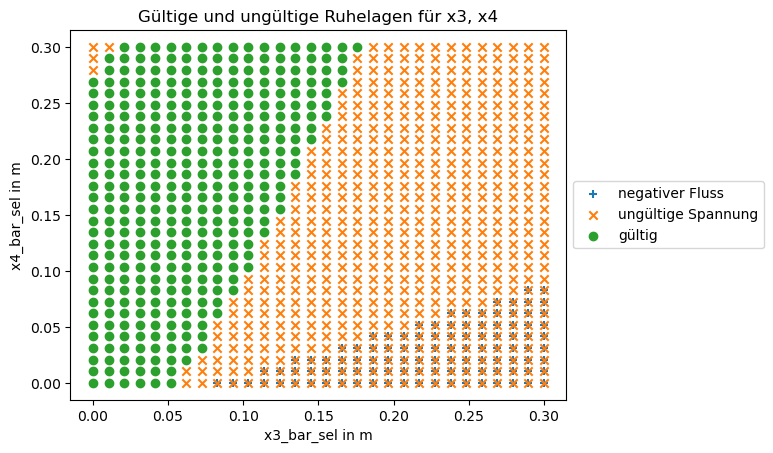

In [9]:
# Now do everything using arrays
# Assuming you have 9 arrays of size (100,)
# Let's call them Q_arrays and U_A_arrays for volume flow and voltage respectively

# Assuming Q_arrays and U_A_arrays are your 9 arrays
#x3_bar = np.linspace(0, hT3, 100)
#x4_bar = np.linspace(0, hT4, 100)
def get_all_system_ss_info(x3_bar,x4_bar):
    # here we assume that the system is always again in steady state
    Q_30 = AS30 * np.sqrt(2 * g * (x3_bar + hV3))
    Q_34 = AS34 * np.sqrt(2 * g * (x3_bar + hV3))
    Q_40 = AS40 * np.sqrt(2 * g * (x4_bar + hV4))

    x2_bar = (1 / AS24 * (Q_40 - Q_34)) ** 2 * 1 / (2 * g) - hV2
    Q_24 = AS24 * np.sqrt(2 * g * (x2_bar + hV2))
    Q_23 = AS23 * np.sqrt(2 * g * (x2_bar + hV2))

    x1_bar = (1 / AS13 * (Q_30 + Q_34 - Q_23)) ** 2 * 1 / (2 * g) - hV1
    Q_12 = AS12 * np.sqrt(2 * g * (x1_bar + hV1))
    Q_13 = AS13 * np.sqrt(2 * g * (x1_bar + hV1))

    Q_01 = Q_12 + Q_13
    Q_02 = Q_23 + Q_24 - Q_12

    U_A1 = Q_01 / Ku1 + uA01
    U_A2 = Q_02 / Ku2 + uA02
    return Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2

def get_cond(Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2):
    positive_flow_condition = np.all([Q_30 > 0, Q_34 > 0, Q_40 > 0, Q_24 > 0, Q_23 > 0, Q_12 > 0, Q_13 > 0, Q_01 > 0, Q_02 > 0], axis = 0)
    voltage_condition = np.all([U_A1 < uAmax1, U_A2 < uAmax2],axis = 0)
    return positive_flow_condition, voltage_condition

length = 30
x3_bar = np.tile(np.linspace(0,hT3,length), length)
x4_bar = np.repeat(np.linspace(0,hT4,length), length)
Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2 = get_all_system_ss_info(x3_bar, x4_bar)

#Check conditions for positive volume flow and voltage below 12
positive_flow_condition, voltage_condition = get_cond(Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2)
#Get the indices where both conditions are satisfied
indices = np.where(positive_flow_condition & voltage_condition)

#get indices where conditions are not satisfied
nflow_indices = np.where(np.logical_not(positive_flow_condition))
nvoltage_indices = np.where(np.logical_not(voltage_condition))
    
if indices[0].size > 0:
    # Accessing elements at the specified indices
    x3_bar_sel = x3_bar[indices]
    x4_bar_sel = x4_bar[indices]


    #plot invalid idz
    plt.scatter(x3_bar[nflow_indices], x4_bar[nflow_indices], label='negativer Fluss', marker='+')
    plt.scatter(x3_bar[nvoltage_indices], x4_bar[nvoltage_indices], label='ungültige Spannung', marker='x')

    # Plotting x3, x4 for possible combinations
    plt.scatter(x3_bar_sel, x4_bar_sel, label='gültig', marker='o')
    plt.title("Gültige und ungültige Ruhelagen für x3, x4")
    plt.xlabel('x3_bar_sel in m')
    plt.ylabel('x4_bar_sel in m')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()


Nur ein Teil der Zustände ist realisierbar. Für $x_4$ sind höhere Zustände erreichbar, da nur ein Abfluss vorhanden ist.

## 3.3 Flachheit

Händisch berechnet. Durch Umstellen auf Q und einsetzen in die Gleichungen für x1, x2 sind alle Zustände und deren Ableitungen über x3, x4 darstellbar.

### Differenzierbarkeit
An Stelle x = 0 nicht gegeben für Q (Sprung)?
Für Zuflüsse mit Pumpe nicht gegeben an Stelle ua0 = uaj (Sprung)

In [10]:
# Declare functions
# Calculate the volume flow given with toricelli
# from sympy.physics.mechanics import *

# x3, x4 = dynamicsymbols('x3 x4')
def fij(aij, xi, hi):
    return aij * sp.sqrt(2 * g * (xi+hi))

# Calculate the volume flow given the pump voltage
def Q0j(K, uAj, uA0j):
    return K * (uAj - uA0j)

# Caclulate the height from given volume flow
def gij(Qij, aij, hi):
    return ( Qij / aij)**2 * 1 / (2*g) - hi

def get_system_info(x3,x4,dt):
    # get system info without assuming steady state condition
    arr_size = np.zeros(1)
    Q24 = arr_size
    Q13 = arr_size
    Q02 = arr_size
    Q01 = arr_size
    UA1 = arr_size
    UA2 = arr_size
    Q12 = arr_size
    Q30 = arr_size
    Q34 = arr_size
    Q40 = arr_size
    Q23 = arr_size
    x1 = arr_size
    x2 = arr_size
    
    
    for i in range(len(x3)-1):
        i = i+1
        Q24 =  np.append(Q24, AT4 * (x4[i]-x4[i-1])/dt - fij(AS34, x3[i], hV3) + fij(AS40,x4[i],hV4))
        x2 = np.append(x2, gij(Q24[i],AS24,hV2))
        Q13 = np.append(Q13, -fij(AS23,x2[i],hV2) + fij(AS34,x3[i],hV3) + fij(AS30,x3[i],hV3) + AT3 * (x3[i]-x3[i-1])/dt )
        x1 = np.append(x1, gij(Q13[i],AS13,hV1))
        # eq II)
        Q02= np.append(Q02, AT2 * (x2[i]-x2[i-1])/dt - fij(AS12,x1[i],hV1) + fij(AS23,x2[i],hV2) + fij(AS24,x2[i],hV2))
        # eq I)
        Q01 = np.append(Q01, AT1 * (x1[i]-x1[i-1])/dt+ fij(AS12,x1[i],hV1) + fij(AS13,x1[i],hV1))
        # Calculating the pump voltages
        UA1 = np.append(UA1, Q01[i] / Ku1 + uA01)
        UA2 = np.append(UA2, Q02[i] / Ku2 + uA02)

        # Calculate all missing volume flows
        Q12 = np.append(Q12,fij(AS12,x1[i],hV1))
        Q30 = np.append(Q30,fij(AS30,x3[i],hV3))
        Q34 = np.append(Q34,fij(AS34, x3[i], hV3))
        Q40 = np.append(Q40,fij(AS40,x4[i],hV4))
        Q23 = np.append(Q23,fij(AS23,x2[i],hV2))
    return Q30[1:], Q34[1:], Q40[1:], x2[1:], Q24[1:], Q23[1:], x1[1:], Q12[1:], Q13[1:], Q01[1:], Q02[1:], UA1[1:], UA2[1:]



# Starting off by calculating Q24
# eq IV)
# Q24 = AT4 * sp.diff(x4) - fij(AS34, x3, hV3) + fij(AS40,x4,hV4)
# x2 = gij(Q24,AS24,hV2)
# eq III) 
# Q13 = -fij(AS23,x2,hV2) + fij(AS34,x3,hV3) + fij(AS30,x3,hV3) + AT3 * sp.diff(x3) 
# x1 = gij(Q13,AS13,hV1)

# eq II)
# Q02 = AT2 * sp.diff(x2) - fij(AS12,x1,hV1) + fij(AS23,x2,hV2) + fij(AS24,x2,hV2)

# eq I)
# Q01 = AT1 * sp.diff(x1)+ fij(AS12,x1,hV1) + fij(AS13,x1,hV1)

# Calculating the pump voltages
# UA1 = Q01 / Ku1 + uA01
# UA2 = Q02 / Ku2 + uA02





## 3.4 Steuerung

Spannungs-Beschränkungen werden über Wahl der Überführungszeit $T$ eingehalten.
Als Beispiel wurde eine Überführung vom Zustand [0,0] auf Zustand [0.05,0.125] abgebildet.

Positive Flow Conditions Satisfied for All Entries: True
Voltage Conditions Satisfied for All Entries: True


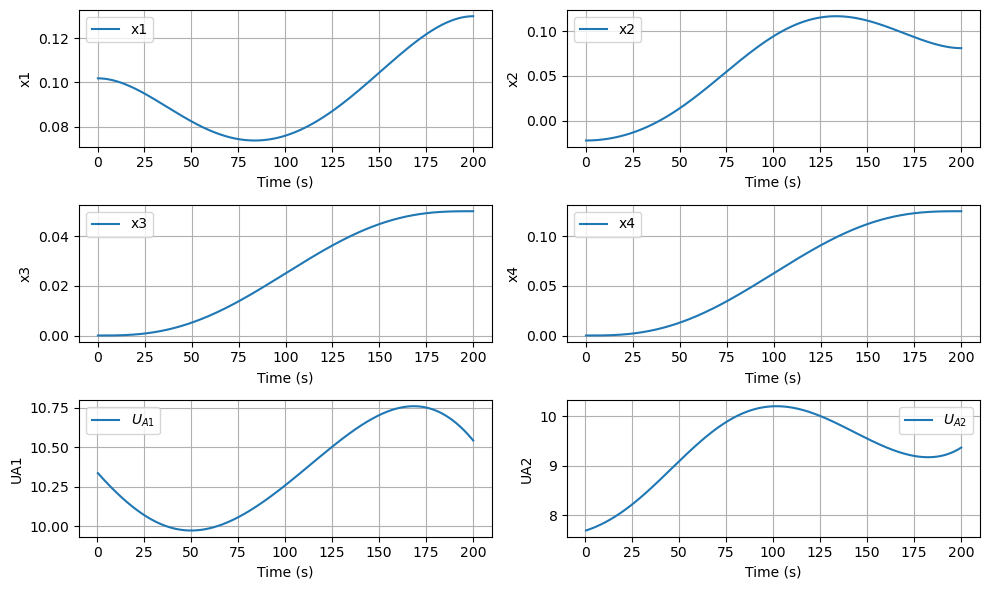

In [13]:
# flatnessbased trajectory control
def prototype_function(ti,T):
    return 30*((ti/T)**3/3 - 2*(ti/T)**4 /4 + (ti/T)**5 /5)

def get_trajectory(t,T,x_i,x_f):
    x = np.zeros((1))
    x = x_i
    for i in range(len(t)-2):
        i = i+1
        temp = x_i + (x_f - x_i)*prototype_function(t[i],T)
        x = np.append(x, temp)
    x = np.append(x,x_f)
    return x

# Now we plan x3 and x4 because they are our flat variables and with them planned in the needed smoothness we get all other variables as well
T = 200 # s transfer time
dt = 0.2 # s time step intervall
t = np.linspace(0,T,round(T/dt))

# initial values
x3_i = 0
x4_i = 0
# final values
x3_f = 0.05
x4_f = 0.125
# planned tajectory
x3_traj = get_trajectory(t,T,x3_i,x3_f)
x4_traj = get_trajectory(t,T,x4_i,x4_f)

# get all values of the other variables and check if the conditions are satisfied
# here we neglected the derivatives we just assumed steady states
Q_30, Q_34, Q_40, x2_traj, Q_24, Q_23, x1_traj, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2 = get_system_info(x3_traj, x4_traj,dt)
#print("U_A1"+str(U_A1)+"\n" +  "U_A2" + str(U_A2))

positive_flow_condition, voltage_condition = get_cond(Q_30, Q_34, Q_40, x2_bar, Q_24, Q_23, x1_bar, Q_12, Q_13, Q_01, Q_02, U_A1, U_A2)
# Get the indices where both conditions are satisfied
indices = np.where(positive_flow_condition & voltage_condition)

# Check conditions for all array entries
all_positive_flow_conditions_satisfied = np.all(positive_flow_condition[1:])
all_voltage_conditions_satisfied = np.all(voltage_condition[1:])

print("Positive Flow Conditions Satisfied for All Entries:", all_positive_flow_conditions_satisfied)
print("Voltage Conditions Satisfied for All Entries:", all_voltage_conditions_satisfied)


# Plotting
plt.figure(figsize=(10, 6))

plt.subplot(3, 2, 1)
plt.plot(t[1:], x1_traj, label='x1')
plt.xlabel('Time (s)')
plt.ylabel('x1')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 2, 2)
plt.plot(t[1:], x2_traj, label='x2')
plt.xlabel('Time (s)')
plt.ylabel('x2')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 2, 3)
plt.plot(t, x3_traj, label='x3')
plt.xlabel('Time (s)')
plt.ylabel('x3')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 2, 4)
plt.plot(t, x4_traj, label='x4')
plt.xlabel('Time (s)')
plt.ylabel('x4')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 2, 5)
plt.plot(t[2:], U_A1[1:], label='$U_{A1}$')
plt.xlabel('Time (s)')
plt.ylabel('UA1')
plt.legend()
plt.grid(visible=True)

plt.subplot(3, 2, 6)
plt.plot(t[2:], U_A2[1:], label='$U_{A2}$')
plt.xlabel('Time (s)')
plt.ylabel('UA2')
plt.legend()
plt.grid(visible=True)

plt.tight_layout()
plt.show()




## Berechnung der Spannung für beliebige Ruhelage

Für VM nicht genutzt. Die benötigte Spannung für die Ruhelage zum Vergleich mit der Sprungantwort wurde aus der geregelten Ruhelage entnommen und für die Sprungantwort eingesetzt.

In [18]:
x3d = 0.05
x4d = 0.125

res = get_all_system_ss_info(x3d, x4d)

print("berechnet \t aus Trajektorie")
print(res[-2], U_A1[-1], sep="\t")
print("berechnet \t aus Trajektorie")
print(res[-1], U_A2[-1], sep="\t")

berechnet 	 aus Trajektorie
10.539244312249899	10.5421461642523
berechnet 	 aus Trajektorie
9.373994513740403	9.36904446241701


## Vergleich von verschiedenen Ruhelagen der Sprungantwort vs Regler (cpp)

Der Vergleich wurde mit alten Parametern durchgeführt. Die Endspannung der geregelten Ruhelage wurde für die Sprungantwort verwendet.

### mit Start bei [0.17, 0.16]

#### [0.2, 0.19]

<img src="img/step_02_019.png">
<img src="img/ctrl_02_019.png">

#### [0.18, 0.14]

<img src="img/step_018_014.png">
<img src="img/ctrl_018_014.png">

#### [0.14, 0.14]

<img src="img/step_014_014.png">
<img src="img/ctrl_014_014.png">

### Start bei [0.05, 0.05]

### [0.2, 0.19]

<img src="img/step_05_to_02_019.png">
<img src="img/ctrl_05_to_02_019.png">

## Regelung (python)

Die Regelparameter wurden wie folgt angesetzt:
$$ K_P = [0.1, 0.1, 0.05, 0.2]$$
$$K_I = [0.1,0.1,0.05,0.1]$$

Die Ableitungen von $x_1$ und $x_2$ wurden vernachlässigt.
Diese könnte man numerisch mithilfe des letzten Zustands berechnen.

### Klasse CascadedControl

```python        
class CascadedControl(pm.Controller):
    """
    Nonlinear cascaded flatness based controller 
    """
    public_settings = OrderedDict([("AT1", st.AT1),
                                   ("AT2", st.AT2),
                                   ("AT3", st.AT3),
                                   ("AT4", st.AT4),
                                   ("hT1", st.hT1),
                                   ("hT2", st.hT2),
                                   ("hT4", st.hT3),
                                   ("hT3", st.hT4),
                                   ("hV1", st.hV1),
                                   ("hV2", st.hV1),
                                   ("hV3", st.hV2),
                                   ("hV4", st.hV4),
                                   ("AS13", st.AS13),
                                   ("AS12", st.AS12),
                                   ("AS23", st.AS23),
                                   ("AS24", st.AS24),
                                   ("AS30", st.AS30),
                                   ("AS34", st.AS34),
                                   ("AS40", st.AS40),
                                   ("g", st.g),
                                   ("Ku1", st.Ku1),
                                   ("Ku2", st.Ku2),
                                   ("uA01", st.uA01),
                                   ("uA02", st.uA02),
                                   ("T1", 10),
                                   ("T2", 10),
                                   ("T3", 20),
                                   ("T4", 20),
                                   ("tick divider", 1), ])

    AS = np.array([[0, 0, 0, 0, 0],
                   [0, 0, st.AS12, st.AS13, 0],
                   [0, 0, 0, st.AS23, st.AS24],
                   [st.AS30, 0, 0, 0, st.AS34],
                   [st.AS40, 0, 0, 0, 0]])

    #errors for I-ctrl
    errs = np.array([0,0,0,0])
    last_time = 0

    def __init__(self, settings):
        # add specific "private" settings
        settings.update(input_order=0)
        settings.update(output_dim=2)
        settings.update(input_type="system_state")

        pm.Controller.__init__(self, settings)
        # self._control(0,trajectory_values=np.array([[0.20],[0.19]]),input_values=[0.05777494, 0.08737835, 0.17 , 0.16])

    def _control(self,
                 time,
                 trajectory_values=None,
                 feedforward_values=None,
                 input_values=None,
                 **kwargs):

        x3d = trajectory_values[0, 0] #0 ,1 wäre erste ableitung!
        x4d = trajectory_values[1, 0]
        #[...]_dot gibt's nicht für die gegebene Trajektorie (polynomiale Überführung wird laut Jens Wurm noch nachgereicht?)
        x3d_dot = 0 #trajectory_values[0,1]
        x4d_dot = 0 #trajectory_values[1,1]

        x = input_values

        #Start Regelung

        #Parameter für P-Regler
        #kp = np.array([0.3,0.3,0.1,0.3])
        #ki = np.array([0,0,0,0])

        #Parameter für PI-Regler
        kp = np.array([0.1,0.1,0.05,0.2])
        ki = np.array([0.1,0.1,0.05,0.1])

        #maximum Füllhöhe für Tanks
        x_max = 0.25

        #äußerer Teil der Kaskade

        #Regelfehler für I-Teil
        dt = time - self.last_time
        self.last_time = time
        self.errs[2] += (x[2]-x3d)*dt
        self.errs[3] += (x[3]-x4d)*dt

        v3 = x3d_dot - kp[2]*(x[2]-x3d) - ki[2]*self.errs[2] # is x_dot3
        v4 = x4d_dot - kp[3]*(x[3]-x4d) - ki[3]*self.errs[3] # is x_dot4

        #ein paar Abkürzungen
        g = self.public_settings["g"]
        s = self.public_settings

        #Flüsse berechnen
        Q34 = self.AS[3,4] * np.sqrt(2*g * (x[2] + s["hV3"]))
        Q30 = self.AS[3,0] * np.sqrt(2*g*(x[2] + s["hV3"]))
        Q23 = self.AS[2,3] * np.sqrt(2*g*(x[1] + s["hV2"]))

        #negative Flüsse auf 0 setzen
        Q34 = Q34 if Q34 > 0 else 0
        Q30 = Q30 if Q30 > 0 else 0
        Q23 = Q23 if Q23 > 0 else 0

        Q13d = Q34 + Q30 - Q23 + s["AT3"]*v3

        Q13d = Q13d if Q13d > 0 else 0

        x1d = Q13d**2 / 2 / self.AS[1,3]**2 / g - s["hV1"]

        #maximum für x1d überprüfen
        x1d = x1d if x1d < x_max else x_max

        Q40 = self.AS[4,0] * np.sqrt(2*g*(x[3] + s["hV4"]))
        Q40 = Q40 if Q40 > 0 else 0
        Q24d = Q40 - Q34 + s["AT4"]*v4
        Q24d = Q24d if Q24d > 0 else 0

        x2d = Q24d**2 / 2 / self.AS[2,4]**2 / g - s["hV2"]
        x2d = x2d if x2d < x_max else x_max

        # innerer Teil der Kaskade

        x1d_dot = 0 #howto? bisher vernachlässigt.
        x2d_dot = 0 #howto?

        self.errs[0] += (x[0]-x1d)*dt
        self.errs[1] += (x[1]-x2d)*dt

        v1 = x1d_dot - kp[0]*(x[0]-x1d) - ki[0]*self.errs[0]   # is x_dot1
        v2 = x2d_dot - kp[1]*(x[1]-x2d) - ki[1]*self.errs[1]   # is x_dot2

        Q12 = self.AS[1,2] * np.sqrt(2*g * (x[0] + s["hV1"]))
        Q13 = self.AS[1,3] * np.sqrt(2*g * (x[0] + s["hV1"]))

        Q12 = Q12 if Q12 > 0 else 0
        Q13 = Q13 if Q13 > 0 else 0

        Q01d = Q12+Q13 + s["AT1"] * v1
        Q01d = Q01d if Q01d > 0 else 0

        Ua1 = Q01d/s["Ku1"] + s["uA01"]

        Ua1 = Ua1 if Ua1 <= 12 else 12
        Ua1 = Ua1 if Ua1 > 0 else 0

        Q02d = Q23 + Q24d - Q12 + s["AT2"] * v2
        Q02d = Q02d if Q02d > 0 else 0

        Ua2 = Q02d/s["Ku2"] + s["uA02"]

        Ua2 = Ua2 if Ua2 <= 12 else 12
        Ua2 = Ua2 if Ua2 > 0 else 0

        # Ende der Implementierung


        return np.array([Ua1, Ua2])         
```

## Regelung (C++)

Die C++-Regelung wurde analog zum python-Skript implementiert. Auch hier wurde die Ableitung von $x_1$ und $x_2$ vernachlässigt.

### Klasse FlatCascadeController

```cpp
class FlatCascadeController : public QuadController {
public:
    QuadTank::Input compute(const QuadTrajType::Des &desState,
                            const QuadTank::State &curState,
                            const uint32_t &dt) override {

        auto x3d = desState.traj[0].y; //x3d[0] x3, x3d[1]: erste Ableitung
        auto x4d = desState.traj[1].y;

        this->x[0] = curState.t(0);
        this->x[1] = curState.t(1);
        this->x[2] = curState.t(2);
        this->x[3] = curState.t(3);

        // Start Regelung

        //Annahme: dt in [ms]
        //zusätzliche Skalierung /1000 für ki-Werte
        double own_dt = dt/1000./1000;

        //Parameter für Regler
        //funktionierender P-Regler
        //Eigen::Matrix<double, 4, 1> kp = {0.1,0.1,0.05,0.1};
        //Eigen::Matrix<double, 4, 1> ki = {0,0,0.0,0.0};

        //TODO: funktionierender PI-Regler
        //andere Verstärkungen wie bei python durch anderes dt??
        Eigen::Matrix<double, 4, 1> kp = {0.1,0.1,0.1,0.1};
        Eigen::Matrix<double, 4, 1> ki = {0,0,0.07,0.05};

        //maximum Füllhöhe der Tanks
        double x_max = 0.25;

        //äußerer Teil der Kaskade

        //Regelfehler für I-Teil
        this->error[2] += (this->x[2]-x3d[0])*own_dt;
        this->error[3] += (this->x[3]-x4d[0])*own_dt;

        double v3 = x3d[1] - kp[2]*(this->x[2]-x3d[0]) - ki[2]* this->error[2];
        double v4 = x4d[1] - kp[3]*(this->x[3]-x4d[0]) - ki[3]* this->error[3];

        //Flüsse berechnen
        double Q34 = TANK34_AOUT * sqrt(2*GRAVITY*(this->x[2]+TANK3_HV));
        double Q30 = TANK30_AOUT * sqrt(2*GRAVITY*(this->x[2]+TANK3_HV));
        double Q23 = TANK23_AOUT * sqrt(2*GRAVITY*(this->x[1]+TANK2_HV));

        Q34 = (Q34<0) ? 0 : Q34;
        Q30 = (Q30<0) ? 0 : Q30;
        Q23 = (Q23<0) ? 0 : Q23;

        double Q13d = Q34 + Q30 - Q23 + TANK3_AT*v3;
        Q13d = (Q13d < 0) ? 0 : Q13d;

        double x1d = Q13d*Q13d / 2 / TANK13_AOUT / TANK13_AOUT / GRAVITY - TANK1_HV;

        x1d = (x1d > x_max) ? x_max : x1d;

        double Q40 = TANK40_AOUT * sqrt(2*GRAVITY*(this->x[3]+TANK4_HV));
        Q40 = (Q40<0) ? 0 : Q40;
        double Q24d = Q40 - Q34 + TANK4_AT*v4;

        double x2d = Q24d*Q24d / 2 / TANK24_AOUT / TANK24_AOUT / GRAVITY - TANK2_HV;
        x2d = (x2d > x_max) ? x_max : x2d;

        //innerer Teil der Kaskade

        double x1d_dot = 0, x2d_dot = 0;

        //Regelfehler für I-Teil
        this->error[0] += (this->x[0]-x1d)*own_dt;
        this->error[1] += (this->x[1]-x2d)*own_dt;

        //nur P-Regler!
        double v1 = x1d_dot - kp[0]*(this->x[0]-x1d) - ki[0]*this->error[0];
        double v2 = x2d_dot - kp[1]*(this->x[1]-x2d) - ki[1]*this->error[1];

        double Q12 = TANK12_AOUT * sqrt(2*GRAVITY*(this->x[0]+TANK1_HV));
        double Q13 = TANK13_AOUT * sqrt(2*GRAVITY*(this->x[0]+TANK1_HV));
        Q13 = (Q13<0) ? 0 : Q13;
        Q12 = (Q12<0) ? 0 : Q12;

        double Q01d = Q12 + Q13 + TANK1_AT*v1;
        Q01d = (Q01d<0) ? 0 : Q01d;

        double Ua1 = Q01d/KU1 + uA01;
        Ua1 = (Ua1 > PWM2VOLT) ? PWM2VOLT : Ua1;

        double Q02d = Q23 + Q24d - Q12 + TANK2_AT * v2;
        Q02d = (Q02d<0) ? 0 : Q02d;

        double Ua2 = Q02d/KU2 +uA02;
        Ua2 = (Ua2 > PWM2VOLT) ? PWM2VOLT : Ua2;


        // Ende der Implementierung
        QuadTank::Input u = { .pump = {Ua1,Ua2} };

        //debug
        //QuadTank::Input d = { .pump = {dt,10} };
        //return d;


        return u;
    }

    void setGains(const double *gains) override {
        this->T1 = gains[0];
        this->T2 = gains[1];
        this->T3 = gains[2];
        this->T4 = gains[3];
    }

    void reset() override {
    }

private:
    double x[6] = {};
    double dx[6] = {};
    double xr[6] = {};
    double dxr[6] = {};
    double ddxr[6] = {};

    double T1 = 0.1;
    double T2 = 0.1;
    double T3 = 0.05;
    double T4 = 0.2;

};         
```